# Final Results: Gross Box Office

Import libraries

In [9]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
import matplotlib
import matplotlib.pyplot as plt
import math
import StringIO
import sklearn
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn import svm
from sklearn.dummy import DummyClassifier as Dummy
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
%matplotlib inline

In [10]:
# read in movie date
movie_data = pd.read_csv('movie_metadata.csv')
movie_data = movie_data[np.isfinite(movie_data['budget'])]
movie_data = movie_data[np.isfinite(movie_data['duration'])]
movie_data = movie_data[np.isfinite(movie_data['gross'])]
movie_data = movie_data[np.isfinite(movie_data['title_year'])]
movie_data = movie_data[np.isfinite(movie_data['cast_total_facebook_likes'])]
movie_data = movie_data[np.isfinite(movie_data['imdb_score'])]

# create genre list
genre_list = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'History', 'Horror', 'Mystery', 'Romance']

# create categorical variables for these common genres
for genre in genre_list:
    lst = []
    for index, row in movie_data.iterrows():
        if (row['genres']).find(genre) != -1:
            lst.append(1)
        else:
            lst.append(0)
    movie_data[genre] = lst

In [11]:
# gets counts of most common directors
counts = pd.value_counts(movie_data['director_name'])
counts = counts[counts > 6]

directors = counts.index.tolist()
print "Number of Directors: ", len(directors)

Number of Directors:  91


In [12]:
# get counts of most common actors
counts_actors = pd.value_counts(movie_data['actor_1_name'])

counts_actors = counts_actors[counts_actors > 7]

actors = counts_actors.index.tolist()
print "Number of Actors: ", len(actors)

Number of Actors:  97


In [13]:
# create categorical values for each director
for director in directors:
    lst = []
    for _, row in movie_data.iterrows():
        if row['director_name'] == director:
            lst.append(1)
        else:
            lst.append(0)
    movie_data[director] = lst

In [14]:
# create categorical values for each actor
for actor in actors:
    lst = []
    for _, row in movie_data.iterrows():
        if row['actor_1_name'] == actor or row['actor_2_name'] == actor or row['actor_3_name'] == actor:
            lst.append(1)
        else:
            lst.append(0)
    movie_data[actor] = lst

In [15]:
# read in inflation file
inf = np.loadtxt('inf.csv')

budget_inf = []
gross_inf = []

# get log value for each budget and gross
for _, row in movie_data.iterrows():
    budget = math.log10(row['budget'])
    gross = math.log10(row['gross'])
    budget_inf.append(budget)
    gross_inf.append(gross)

# create columns for log values
movie_data['budget_inf'] = budget_inf
movie_data['gross_inf'] = gross_inf

In [183]:
### predict gross box office

train_test = pd.DataFrame({})

for genre in genre_list:
    train_test = pd.concat([train_test, movie_data[genre]], axis = 1)

train_test = pd.concat([train_test, movie_data[directors]], axis = 1)
train_test = pd.concat([train_test, movie_data[actors]], axis = 1)
train_test = pd.concat([train_test, movie_data['budget']], axis = 1)
train_test = pd.concat([train_test, movie_data['title_year']], axis = 1)
train_test = pd.concat([train_test, movie_data['gross']], axis = 1)
train_test = pd.concat([train_test, movie_data['duration']], axis = 1)
train_test = pd.concat([train_test, pd.get_dummies(movie_data['content_rating'])], axis = 1)

training, testing = sklearn.model_selection.train_test_split(train_test, train_size = 0.4, test_size = 0.6)

rfr_model = RFR(max_depth = 7, n_estimators =10)

rfr_model.fit(training.drop('gross', axis=1), training['gross'])

print "Random Forest Regression (depth 7) Model on Training Set", rfr_model.score(training.drop('gross', axis = 1), training['gross'])
print "Random Forest Regression (depth 7) Model on Testing Set", rfr_model.score(testing.drop('gross', axis = 1), testing['gross'])

Random Forest Regression (depth 7) Model on Training Set 0.697247639879
Random Forest Regression (depth 7) Model on Testing Set 0.489158064347


In [184]:
# get random sample of movie data
_, sample = sklearn.model_selection.train_test_split(train_test, test_size = .02)
actual = sample['gross']
predictions = rfr_model.predict(sample.drop('gross', axis = 1))

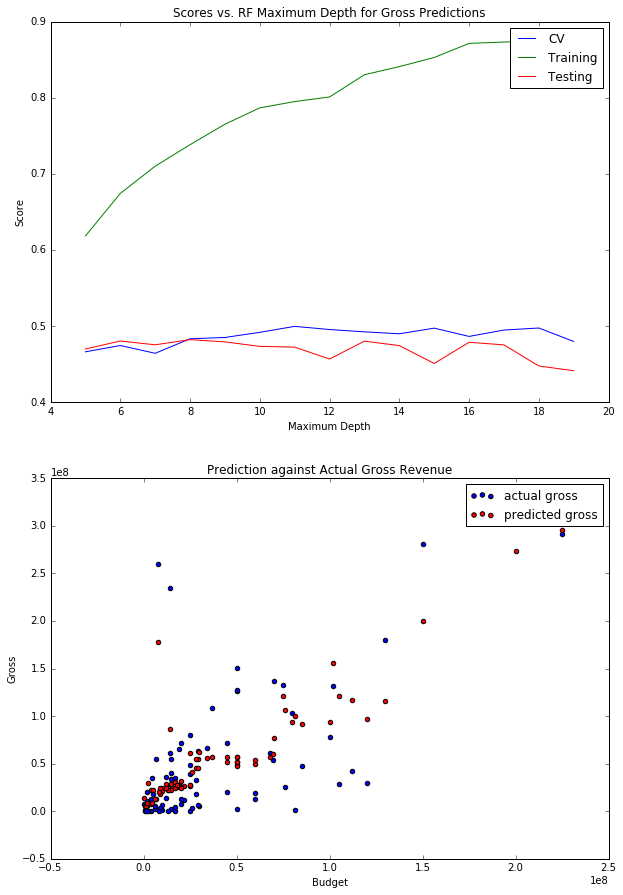

In [186]:
# make lists for CV, training, and testing scores
cv_list = []
test_scores = []
train_scores = []
train_test_shuffled = shuffle(train_test)

# for each max depth value, get CV, training, and testing scores
for i in range(5,20):
    rfr_model = RFR(max_depth = i)
    cv_scores = cross_val_score(rfr_model, train_test_shuffled.drop('gross',axis=1), train_test_shuffled['gross'], cv = 5)
    cv_list.append(np.mean(cv_scores))
    rfr_model.fit(training.drop('gross', axis=1), training['gross'])
    train_scores.append(rfr_model.score(training.drop('gross', axis=1), training['gross']))
    test_scores.append(rfr_model.score(testing.drop('gross', axis=1), testing['gross']))

# plot values
fig = plt.figure(figsize = (10,15))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(range(5,20), cv_list, label= 'CV')
ax1.plot(range(5,20), train_scores, c = 'g', label = 'Training')
ax1.plot(range(5,20), test_scores, c='r', label = 'Testing')
ax1.set_title('Scores vs. RF Maximum Depth for Gross Predictions')
ax1.set_xlabel('Maximum Depth')
ax1.set_ylabel('Score')
ax1.legend()

ax2.scatter(sample['budget'], actual, label='actual gross')
ax2.scatter(sample['budget'], predictions, c = 'r', label='predicted gross')
ax2.set_title('Prediction against Actual Gross Revenue')
ax2.set_xlabel('Budget')
ax2.set_ylabel('Gross')
ax2.legend()

In [19]:
# create classes for gross box office
lst = []
for index, row in movie_data.iterrows():
        if row['gross'] > 600000000:
            lst.append(5)
        elif row['gross'] > 200000000:
            lst.append(4)
        elif row['gross'] > 50000000:
            lst.append(3)
        elif row['gross'] > 10000000: 
            lst.append(2)
        else:
            lst.append(1)

movie_data['gross_class'] = lst

In [20]:
# create dataframe of relevent variables
train_test = pd.DataFrame({})

for genre in genre_list:
    train_test = pd.concat([train_test, movie_data[genre]], axis = 1)

train_test = pd.concat([train_test, movie_data[directors]], axis = 1)
train_test = pd.concat([train_test, movie_data[actors]], axis = 1)
train_test = pd.concat([train_test, movie_data['budget']], axis = 1)
train_test = pd.concat([train_test, movie_data['duration']], axis = 1)
train_test = pd.concat([train_test, movie_data['gross_class']], axis = 1)
train_test = pd.concat([train_test, movie_data['title_year']], axis = 1)

training, testing = sklearn.model_selection.train_test_split(train_test, train_size = 0.4, test_size = 0.6)

In [22]:
# score dummy model for gross box office class
print "Box Office class (unadjusted)"
d_model = Dummy()
d_model.fit(training.drop('gross_class', axis=1), training['gross_class'])
print "\tDummy Model", d_model.score(testing.drop('gross_class', axis = 1), testing['gross_class'])

# score RFC model
rfc_model = RFC(max_depth=9)
rfc_model.fit(training.drop('gross_class', axis=1), training['gross_class'])
print "\tRandom Forest Classifier Model", rfc_model.score(testing.drop('gross_class', axis = 1), testing['gross_class'])

Box Office class (unadjusted)
	Dummy Model 0.313196229649
	Random Forest Classifier Model 0.558269065981
